# Syslog CSV Breakdown

This script uses pandas to generate:

- Simple plot of of a syslog.csv. The csv file has been previously created by [syslog-to-csv.py](https://github.com/gm3dmo/syslog-to-csv/blob/main/syslog-to-csv.py)
- Summary and count of the daemons which wrote to sylog in csv and markdown format.


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pathlib
cwd = pathlib.Path.cwd()

In [3]:
pd.set_option('display.max_rows', 1000)
csv_file = cwd / 'syslog.csv'
df = pd.read_csv(csv_file)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8715277 entries, 0 to 8715276
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   line_number     int64  
 1   line_length     int64  
 2   extracted_date  object 
 3   unix_timestamp  float64
 4   real_date       object 
 5   hostname        object 
 6   daemon          object 
 7   wiped_line      object 
dtypes: float64(1), int64(2), object(5)
memory usage: 531.9+ MB


Create a pandas datetime column called `real_date` using the `unix_timestamp` column as a source:

In [5]:
df['real_date'] = pd.to_datetime(df['unix_timestamp'],unit='s')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8715277 entries, 0 to 8715276
Data columns (total 8 columns):
 #   Column          Dtype         
---  ------          -----         
 0   line_number     int64         
 1   line_length     int64         
 2   extracted_date  object        
 3   unix_timestamp  float64       
 4   real_date       datetime64[ns]
 5   hostname        object        
 6   daemon          object        
 7   wiped_line      object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 531.9+ MB


Create the time period *buckets* in which to group the data. In this script We've chosen `600S` (10 minutes) for the granularity of the bucket. Other frequencies can be chosen and are documented in the [offset-aliases](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases). To choose a different *bucket size*, simply replace the `600S` with a new value where you see `freq='600S'`

In [6]:
buckets = df.groupby([pd.Grouper(key='real_date', axis=0, freq='600S'),'daemon']).count()

In [7]:
buckets

line_number  line_length  \
real_date           daemon                                           
2022-03-26 00:40:00 aqueduct-lite                  97           97   
                    authzd                        116          116   
                    babeld                      25666        25666   
                    codeload                     1267         1267   
                    dependency-graph-api          127          127   
...                                               ...          ...   
2022-03-26 10:10:00 kernel:                         2            2   
                    nomad                          16           16   
                    spokesd                       207          207   
                    systemd                        91           91   
                    systemd-udevd                   5            5   

                                          extracted_date  unix_timestamp  \
real_date           daemon                                                 
2022-03-26 00:40:00 aqueduct-lite                     97              97   
                    authzd                           116             116   
                    babeld                         25666           25666   
                    codeload                        1267            1267   
                    dependency-graph-api             127             127   
...                                                  ...             ...   
2022-03-26 10:10:00 kernel:                            2               2   
                    nomad                             16              16   
                    spokesd                          207             207   
                    systemd                           91              91   
                    systemd-udevd                      5               5   

                                          hostname  wiped_line  
real_date           daemon                                      
2022-03-26 00:40:00 aqueduct-lite               97          97  
                    authzd                     116         116  
                    babeld                   25666       25666  
                    codeload                  1267        1267  
                    dependency-graph-api       127         127  
...                                            ...         ...  
2022-03-26 10:10:00 kernel:                      2           2  
                    nomad                       16          16  
                    spokesd                    207         207  
                    systemd                     91          91  
                    systemd-udevd                5           5  

[1326 rows x 6 columns]

#### Which daemons are producing the most messages per 10 minutes?

In [8]:
buckets_of_wiped_line = df.groupby([pd.Grouper(key='real_date', axis=0, freq='600S'),'daemon'])['wiped_line'].count().unstack()

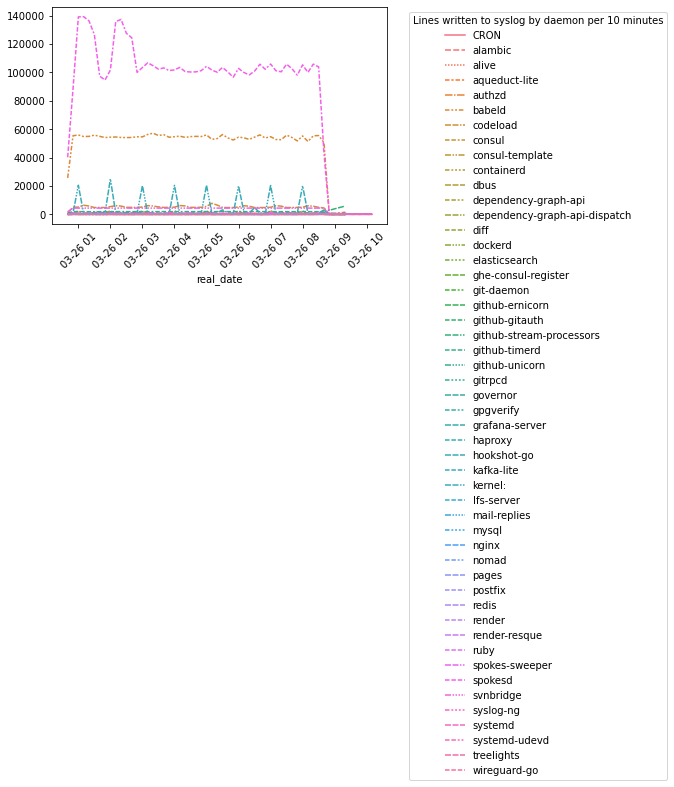

In [9]:
sns.lineplot(data = buckets_of_wiped_line)
plt.xticks(rotation=45)
plt.legend(title = "Lines written to syslog by daemon per 10 minutes", bbox_to_anchor=(1.05, 1))

### Generate summaries of the bucket data

In [ ]:
buckets_of_wiped_line.to_markdown('syslog-10-minute-breakdown.md')

In [ ]:
buckets_of_wiped_line.to_csv('syslog-10-minute-breakdown.csv')